In [1]:
!pip install numpy
!pip install matplotlib
!pip install scikit-learn
!pip install torch
!pip install pennylane
!pip install pytorch
!pip install pytorch-lightning
!pip install qiskit
!pip install qiskit-algorithms


  Using cached autograd-1.6.2-py3-none-any.whl.metadata (706 bytes)
  Using cached appdirs-1.4.4-py2.py3-none-any.whl.metadata (9.0 kB)
  Using cached semantic_version-2.10.0-py2.py3-none-any.whl.metadata (9.7 kB)
  Using cached future-1.0.0-py3-none-any.whl.metadata (4.0 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 20.7 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.8/49.8 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.5/18.5 MB 104.2 MB/s eta 0:00:0000:0100:01
Using cached semantic_version-2.10.0-py2.py3-none-any.whl (15 kB)
Using cached appdirs-1.4.4-py2.py3-none-any.whl (9.6 kB)
Using cached autograd-1.6.2-py3-none-any.whl (49 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 107.3 MB/s eta 0:00:00
Using cached future-1.0.0-py3-none-any.whl (491 kB)
  Using cached pytorch-1.0.2.tar.gz (689 bytes)
  Preparing metadata (setup.py) ... done
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel d

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
from torch import Tensor
from torch.nn import Parameter
import torch.utils.data as Data
from torch.utils.data import RandomSampler
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
from sklearn.metrics import mean_squared_error
import pennylane as qml
import pytorch_lightning as pl
import math
import time



In [6]:
dfi = pd.read_csv('https://raw.githubusercontent.com/SPUTnik-42/Q-LSTM/main/kaggle/AQI%20Data.csv')
dfi

,T,TM,Tm,SLP,H,VV,V,VM,PM 2.5
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,7.4,9.8,4.8,1017.6,93.0,0.5,4.3,9.4,219.720833
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,7.8,12.7,4.4,1018.5,87.0,0.6,4.4,11.1,182.187500
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
2187,16.3,23.3,9.0,1017.1,68.0,1.3,7.8,18.3,182.583333
2188,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2189,17.4,23.6,9.7,1019.7,70.0,2.6,8.0,20.6,184.208333
2190,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
dfi.dropna()
df = dfi.dropna()

In [9]:
df = df.reset_index()
df = df.drop(['index','TM','Tm','SLP','VV','VM'], axis=1)
df

,T,H,V,PM 2.5
0,7.4,93.0,4.3,219.720833
1,7.8,87.0,4.4,182.187500
2,6.7,82.0,4.8,154.037500
3,8.6,72.0,8.1,223.208333
4,12.4,61.0,8.7,200.645833
...,...,...,...,...
1090,16.3,78.0,7.4,186.041667
1091,16.3,68.0,7.8,185.583333
1092,16.3,68.0,7.8,182.583333
1093,17.4,70.0,8.0,184.208333


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1095 entries, 0 to 1094
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   T       1095 non-null   float64
 1   H       1095 non-null   float64
 2   V       1095 non-null   float64
 3   PM 2.5  1095 non-null   float64
dtypes: float64(4)
memory usage: 34.3 KB


In [11]:
size = int(len(df) * 0.8)

train = df.iloc[:size].copy()
test = df.iloc[size:].copy()
train

,T,H,V,PM 2.5
0,7.4,93.0,4.3,219.720833
1,7.8,87.0,4.4,182.187500
2,6.7,82.0,4.8,154.037500
3,8.6,72.0,8.1,223.208333
4,12.4,61.0,8.7,200.645833
...,...,...,...,...
871,28.6,49.0,11.5,82.833333
872,28.3,53.0,9.1,95.250000
873,26.8,57.0,5.7,115.833333
874,27.6,53.0,5.9,136.708333


In [12]:
train.iloc[:,-1:]

,PM 2.5
0,219.720833
1,182.187500
2,154.037500
3,223.208333
4,200.645833
...,...
871,82.833333
872,95.250000
873,115.833333
874,136.708333


In [13]:
train.iloc[:,:3]

,T,H,V
0,7.4,93.0,4.3
1,7.8,87.0,4.4
2,6.7,82.0,4.8
3,8.6,72.0,8.1
4,12.4,61.0,8.7
...,...,...,...
871,28.6,49.0,11.5
872,28.3,53.0,9.1
873,26.8,57.0,5.7
874,27.6,53.0,5.9


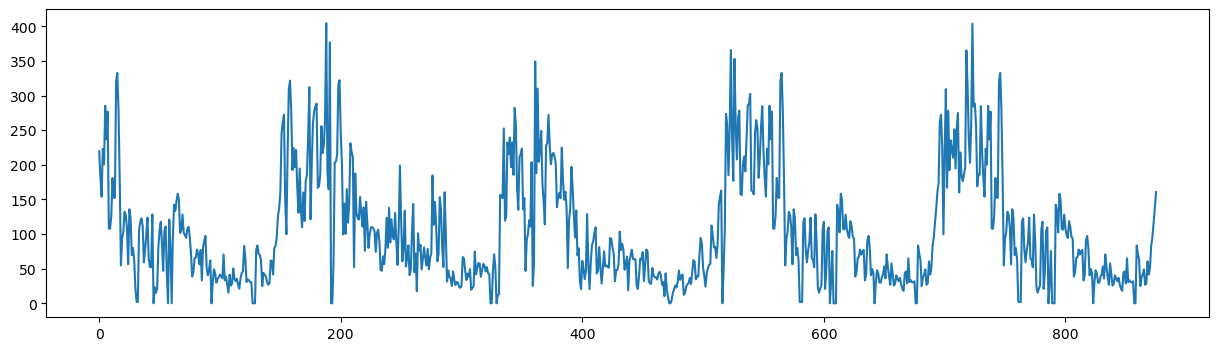

In [15]:
%matplotlib inline
plt.figure(figsize=(15, 4))
plt.plot(range(len(train)), train["PM 2.5"])
plt.show()

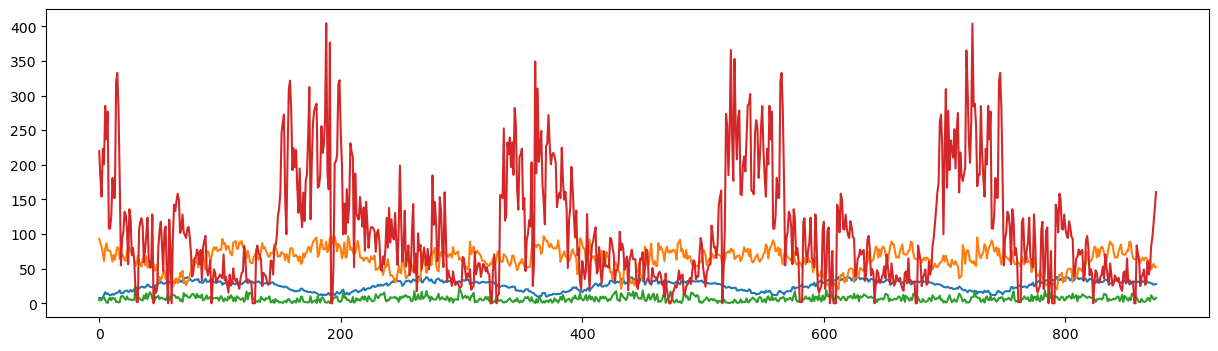

In [16]:
plt.figure(figsize=(15, 4))
plt.plot(train)
plt.show()

In [17]:
def data_process(data, window_size, predict_size):
    scaler1 = StandardScaler()
    scaler2 = StandardScaler()
    d_y = scaler1.fit_transform(data.iloc[:,-1:])
    data = scaler2.fit_transform(data.iloc[:,:4])

    data_in = []
    data_out = []
    # range(window_size,len(data)-predict_size+1) range(data.shape[0] - window_size - predict_size + 1)
    for i in range(window_size,len(data)-predict_size+1):
        data_in.append(data[i-window_size:i,0:data.shape[0]])
        data_out.append(d_y[i + predict_size - 1:i + predict_size,0])

    data_in = np.array(data_in)
    data_out = np.array(data_out)

    data_process = {'datain': data_in, 'dataout': data_out}

    return data_process, scaler1 , scaler2

In [18]:
from numpy.random import default_rng
from qiskit_algorithms.utils import algorithm_globals
qubits = 4
seed = 42
np.random.seed(seed)
torch.manual_seed(42)
rng = default_rng(seed)
algorithm_globals.random_seed = seed
features_size = 4
#window_size = features_size * 3
window_size = 10
predict_size = 1

In [19]:
train_processed, train_target_scalar, train_scaler = data_process(train, window_size, predict_size)
X_train, y_train = train_processed['datain'], train_processed['dataout']

test_processed, test_target_scalar, test_scaler = data_process(test, window_size, predict_size)
X_test, y_test = test_processed['datain'], test_processed['dataout']

In [20]:
X_train = torch.from_numpy(X_train.astype(np.float32))
X_test = torch.from_numpy(X_test.astype(np.float32))

y_train = torch.from_numpy(y_train.astype(np.float32))
y_test = torch.from_numpy(y_test.astype(np.float32))

In [21]:
print(X_train.shape)
X_train[0][0]

torch.Size([866, 10, 4])


tensor([-2.5577,  1.8798, -0.6244,  1.4382])

In [22]:
class QLSTM(nn.Module):
    def __init__(self,
                input_size,
                hidden_size,
                n_qubits=4,
                n_qlayers=1,
                batch_first=True,
                return_sequences=False,
                return_state=False,
                backend="default.qubit"):
        super(QLSTM, self).__init__()
        self.n_inputs = input_size
        self.hidden_size = hidden_size
        self.concat_size = self.n_inputs + self.hidden_size
        self.n_qubits = n_qubits
        self.n_qlayers = n_qlayers
        self.backend = backend  # "default.qubit", "qiskit.basicaer", "qiskit.ibm"

        self.batch_first = batch_first
        self.return_sequences = return_sequences
        self.return_state = return_state

        #self.dev = qml.device("default.qubit", wires=self.n_qubits)
        #self.dev = qml.device('qiskit.basicaer', wires=self.n_qubits)
        #self.dev = qml.device('qiskit.ibm', wires=self.n_qubits)
        # use 'qiskit.ibmq' instead to run on hardware

        self.wires_forget = [f"wire_forget_{i}" for i in range(self.n_qubits)]
        self.wires_input = [f"wire_input_{i}" for i in range(self.n_qubits)]
        self.wires_update = [f"wire_update_{i}" for i in range(self.n_qubits)]
        self.wires_output = [f"wire_output_{i}" for i in range(self.n_qubits)]

        self.dev_forget = qml.device(self.backend, wires=self.wires_forget)
        self.dev_input = qml.device(self.backend, wires=self.wires_input)
        self.dev_update = qml.device(self.backend, wires=self.wires_update)
        self.dev_output = qml.device(self.backend, wires=self.wires_output)

        def _circuit_forget(inputs, weights):
            qml.templates.AngleEmbedding(inputs, wires=self.wires_forget)
            qml.templates.BasicEntanglerLayers(weights, wires=self.wires_forget)
            return [qml.expval(qml.PauliZ(wires=w)) for w in self.wires_forget]
        self.qlayer_forget = qml.QNode(_circuit_forget, self.dev_forget, interface="torch")

        def _circuit_input(inputs, weights):
            qml.templates.AngleEmbedding(inputs, wires=self.wires_input)
            qml.templates.BasicEntanglerLayers(weights, wires=self.wires_input)
            return [qml.expval(qml.PauliZ(wires=w)) for w in self.wires_input]
        self.qlayer_input = qml.QNode(_circuit_input, self.dev_input, interface="torch")

        def _circuit_update(inputs, weights):
            qml.templates.AngleEmbedding(inputs, wires=self.wires_update)
            qml.templates.BasicEntanglerLayers(weights, wires=self.wires_update)
            return [qml.expval(qml.PauliZ(wires=w)) for w in self.wires_update]
        self.qlayer_update = qml.QNode(_circuit_update, self.dev_update, interface="torch")

        def _circuit_output(inputs, weights):
            qml.templates.AngleEmbedding(inputs, wires=self.wires_output)
            qml.templates.BasicEntanglerLayers(weights, wires=self.wires_output)
            return [qml.expval(qml.PauliZ(wires=w)) for w in self.wires_output]
        self.qlayer_output = qml.QNode(_circuit_output, self.dev_output, interface="torch")

        weight_shapes = {"weights": (n_qlayers, n_qubits)}
        print(f"weight_shapes = (n_qlayers, n_qubits) = ({n_qlayers}, {n_qubits})")

        self.clayer_in = torch.nn.Linear(self.concat_size, n_qubits)
        self.VQC = {
            'forget': qml.qnn.TorchLayer(self.qlayer_forget, weight_shapes),
            'input': qml.qnn.TorchLayer(self.qlayer_input, weight_shapes),
            'update': qml.qnn.TorchLayer(self.qlayer_update, weight_shapes),
            'output': qml.qnn.TorchLayer(self.qlayer_output, weight_shapes)
        }
        self.clayer_out = torch.nn.Linear(self.n_qubits, self.hidden_size)
        #self.clayer_out = [torch.nn.Linear(n_qubits, self.hidden_size) for _ in range(4)]

    def forward(self, x, init_states=None):
        '''
        x.shape is (batch_size, seq_length, feature_size)
        recurrent_activation -> sigmoid
        activation -> tanh
        '''
        if self.batch_first is True:
            batch_size, seq_length, features_size = x.size()
        else:
            seq_length, batch_size, features_size = x.size()

        hidden_seq = []
        if init_states is None:
            h_t = torch.zeros(batch_size, self.hidden_size)  # hidden state (output)
            c_t = torch.zeros(batch_size, self.hidden_size)  # cell state
        else:
            # for now we ignore the fact that in PyTorch you can stack multiple RNNs
            # so we take only the first elements of the init_states tuple init_states[0][0], init_states[1][0]
            h_t, c_t = init_states
            h_t = h_t[0]
            c_t = c_t[0]

        for t in range(seq_length):
            # get features from the t-th element in seq, for all entries in the batch
            x_t = x[:, t, :]

            # Concatenate input and hidden state
            v_t = torch.cat((h_t, x_t), dim=1)

            # match qubit dimension
            y_t = self.clayer_in(v_t)

            f_t = torch.sigmoid(self.clayer_out(self.VQC['forget'](y_t)))  # forget block
            i_t = torch.sigmoid(self.clayer_out(self.VQC['input'](y_t)))  # input block
            g_t = torch.tanh(self.clayer_out(self.VQC['update'](y_t)))  # update block
            o_t = torch.sigmoid(self.clayer_out(self.VQC['output'](y_t))) # output block

            c_t = (f_t * c_t) + (i_t * g_t)
            h_t = o_t * torch.tanh(c_t)

            hidden_seq.append(h_t.unsqueeze(0))
        hidden_seq = torch.cat(hidden_seq, dim=0)
        hidden_seq = hidden_seq.transpose(0, 1).contiguous()
        return hidden_seq, (h_t, c_t)

class QRegressionLSTM(nn.Module):
    def __init__(self, num_sensors, hidden_units, n_qubits=0, n_qlayers=1):
        super().__init__()
        self.num_sensors = num_sensors  # this is the number of features
        self.hidden_units = hidden_units
        self.num_layers = 1

        self.lstm = QLSTM(
            input_size=num_sensors,
            hidden_size=hidden_units,
            batch_first=True,
            n_qubits = n_qubits,
            n_qlayers= n_qlayers
        )

        self.linear = nn.Linear(in_features=self.hidden_units, out_features=1)

    def forward(self, x):
        batch_size = x.shape[0]
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_units).requires_grad_()
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_units).requires_grad_()

        _, (hn, _) = self.lstm(x, (h0, c0))
        out = self.linear(hn).flatten()  # First dim of Hn is num_layers, which is set to 1 above.

        return out

In [24]:
batch_size = 4
learning_rate = 0.004
num_epochs = 5
trainDataloader = DataLoader(TensorDataset(X_train, y_train), batch_size = batch_size, shuffle = False)
testDataloader = DataLoader(TensorDataset(X_test,y_test), batch_size = batch_size, shuffle = False)
device = "cpu"
modelQ = QRegressionLSTM(num_sensors=4, hidden_units= 12, n_qubits=4)
criterion = nn.MSELoss()
optimizerQ = torch.optim.Adam(modelQ.parameters(), lr = learning_rate, betas = (0.0, 0.9))

weight_shapes = (n_qlayers, n_qubits) = (1, 4)


In [80]:
histQ = np.zeros(num_epochs)
histQacc = np.zeros(num_epochs)
count = 0
for epoch in range(num_epochs):
    loss_Q = []
    rmse_q = []
    correct = 0
    batches = 0
    for (x, y) in trainDataloader:
        modelQ.zero_grad()
        x = x.to(device)
        y = y.to(device)
        output = modelQ(x)

        label = y.squeeze(1)
        #print(output)
        #print(label)
        lossQ = criterion(output, label)
        lossQ.backward()
        optimizerQ.step()
        #correct += (output == label).float().sum()
        #batches +=1
        loss_Q.append(lossQ.item())
    histQ[epoch] = np.sum(loss_Q)

    #print(correct)
    #histQacc[epoch] = correct/batches
    print(f'[{epoch+1}/{num_epochs}]  LossQ:{histQ[epoch]}')

[1/5]  LossQ:0.2940040414858918
[2/5]  LossQ:0.29417239127504696
[3/5]  LossQ:0.29370753659141435
[4/5]  LossQ:0.29302819671371116
[5/5]  LossQ:0.2920710273979721


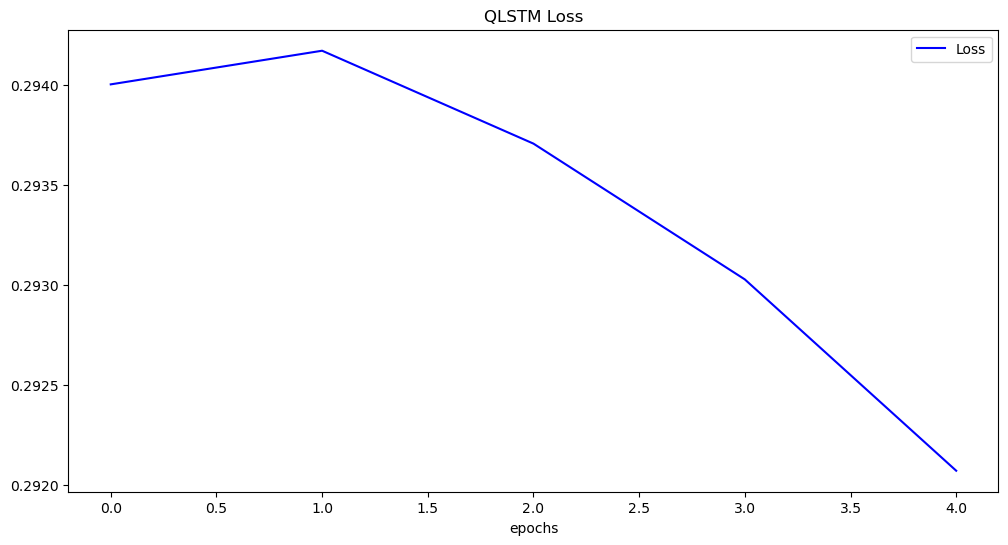

In [81]:
plt.figure(figsize = (12, 6))
plt.plot(histQ, color = 'blue', label = 'Loss')
plt.title('QLSTM Loss')
plt.xlabel('epochs')
plt.legend(loc = 'upper right')

In [82]:
def predict(data_loader, model):
    """Just like `test_loop` function but keep track of the outputs instead of the loss
    function.
    """
    output = torch.tensor([])
    model.eval()
    with torch.no_grad():
        for X, _ in data_loader:
            y_star = model(X)
            output = torch.cat((output, y_star), 0)


    return output

In [83]:
pred_y_train = modelQ(X_train)
pred_y_test = modelQ(X_test)

print(pred_y_train)

tensor([ 6.1814e-01,  9.4588e-01,  1.2576e+00,  1.2020e+00,  1.2281e+00,
         2.0104e+00,  1.8139e+00,  1.4005e+00,  1.0349e+00,  6.8167e-02,
        -1.5117e-01,  3.5991e-02,  3.8873e-01,  4.7328e-01,  3.2308e-02,
        -4.6954e-01,  2.6418e-01,  1.7366e-01, -3.8306e-01, -3.0928e-01,
        -5.1262e-01, -2.8649e-01, -6.6421e-01, -7.2238e-01,  1.2886e-02,
         7.9990e-02,  2.3888e-01,  1.1634e-01, -6.2361e-01, -1.7873e-01,
        -5.1570e-01,  3.0514e-01, -6.1786e-01, -4.4647e-01, -5.7735e-01,
         2.7560e-01, -7.6285e-01, -4.3641e-01, -7.7843e-01, -6.2683e-01,
        -1.9209e-01,  7.8552e-02,  2.0851e-03, -3.1344e-01, -5.2371e-01,
         1.0643e-01,  2.1230e-02, -6.5185e-01, -5.8433e-01,  3.2171e-01,
        -5.1726e-01, -6.8025e-01, -3.9624e-02,  2.7878e-01,  2.0997e-01,
         7.3462e-01,  6.0410e-01,  7.5000e-01,  1.5499e-01,  2.4500e-01,
         6.9990e-01, -1.7805e-01, -1.6629e-01, -2.3543e-01,  1.7538e-01,
        -1.0128e-01,  7.2170e-03, -4.6457e-01, -5.2

In [84]:
pred_y_train = pred_y_train.reshape(-1, 1)
pred_y_test = pred_y_test.reshape(-1, 1)


In [85]:
pred_y_train

tensor([[ 6.1814e-01],
        [ 9.4588e-01],
        [ 1.2576e+00],
        [ 1.2020e+00],
        [ 1.2281e+00],
        [ 2.0104e+00],
        [ 1.8139e+00],
        [ 1.4005e+00],
        [ 1.0349e+00],
        [ 6.8167e-02],
        [-1.5117e-01],
        [ 3.5991e-02],
        [ 3.8873e-01],
        [ 4.7328e-01],
        [ 3.2308e-02],
        [-4.6954e-01],
        [ 2.6418e-01],
        [ 1.7366e-01],
        [-3.8306e-01],
        [-3.0928e-01],
        [-5.1262e-01],
        [-2.8649e-01],
        [-6.6421e-01],
        [-7.2238e-01],
        [ 1.2886e-02],
        [ 7.9990e-02],
        [ 2.3888e-01],
        [ 1.1634e-01],
        [-6.2361e-01],
        [-1.7873e-01],
        [-5.1570e-01],
        [ 3.0514e-01],
        [-6.1786e-01],
        [-4.4647e-01],
        [-5.7735e-01],
        [ 2.7560e-01],
        [-7.6285e-01],
        [-4.3641e-01],
        [-7.7843e-01],
        [-6.2683e-01],
        [-1.9209e-01],
        [ 7.8552e-02],
        [ 2.0851e-03],
        [-3

In [86]:
y_train_true = train_target_scalar.inverse_transform(y_train)
y_train_pred = train_target_scalar.inverse_transform(pred_y_train.cpu().detach().numpy())
y_test_true = test_target_scalar.inverse_transform(y_test)
y_test_pred = test_target_scalar.inverse_transform(pred_y_test.cpu().detach().numpy())

Training dataset MSE:1858.728011073252


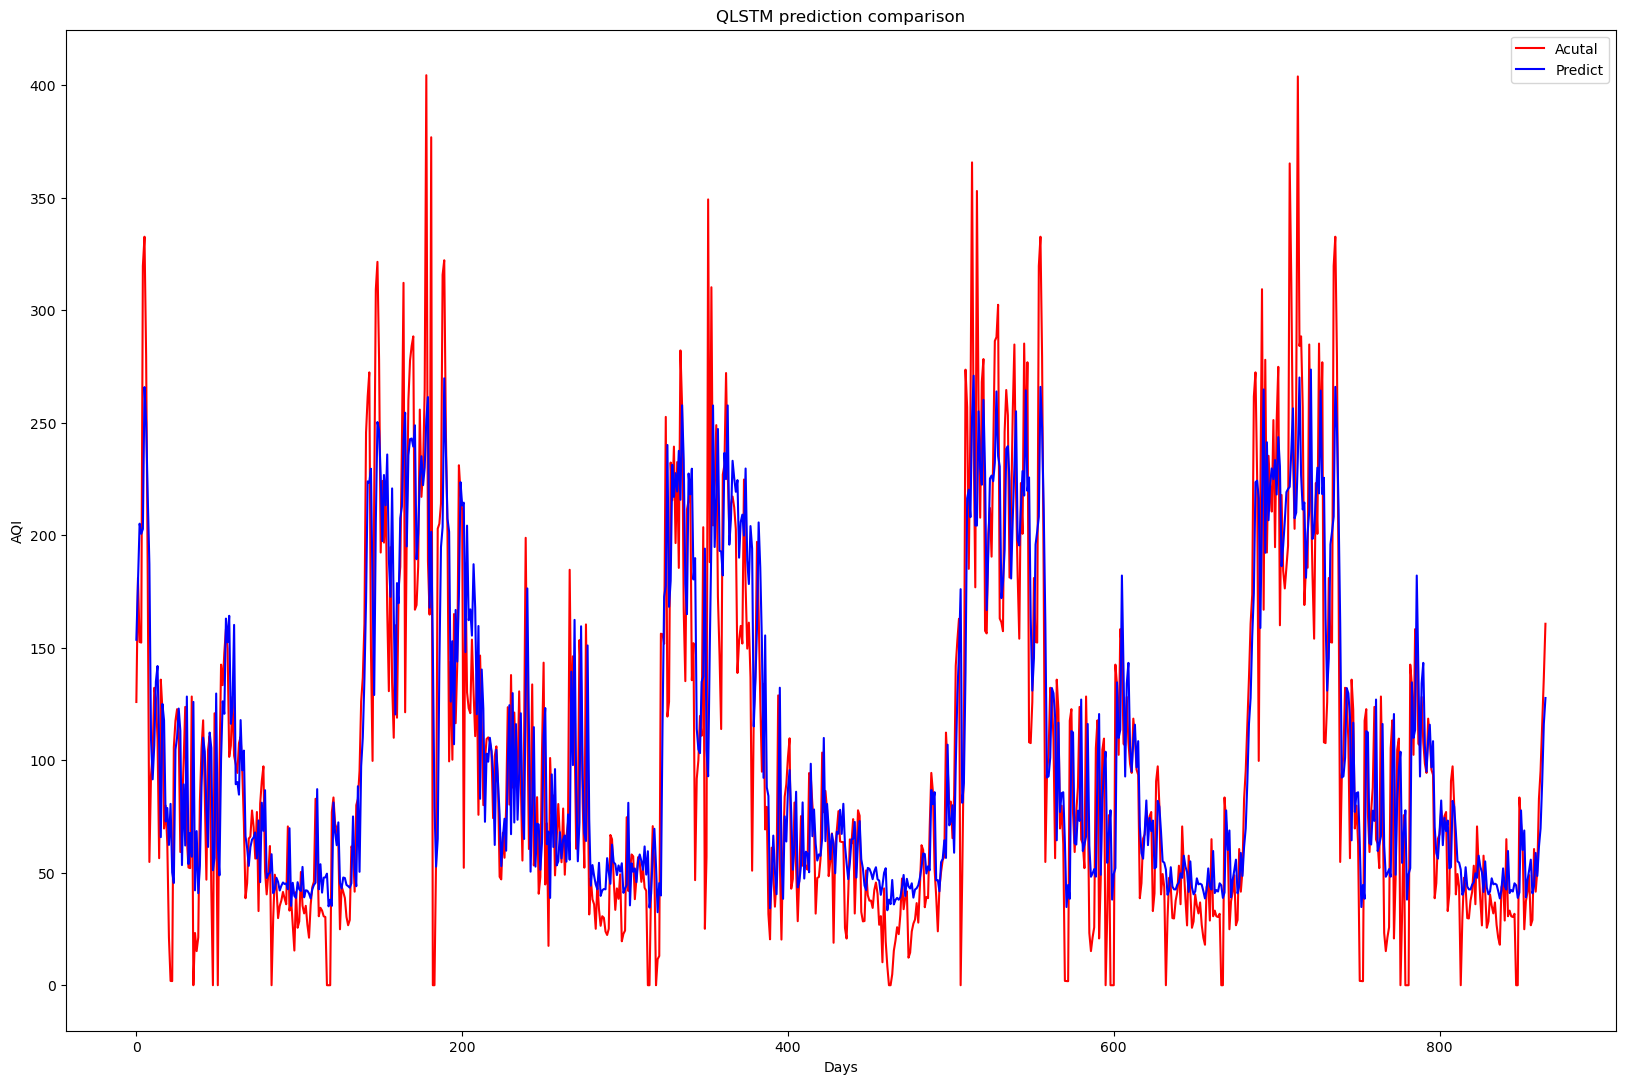

In [87]:
plt.figure(figsize=(20, 13))
plt.plot(y_train_true, color = 'red', label = 'Acutal')
plt.plot(y_train_pred, color = 'blue', label = 'Predict')
plt.title('QLSTM prediction comparison')
plt.ylabel('AQI')
plt.xlabel('Days')
plt.legend(loc = 'upper right')

Trmse = []
ytt = y_train_true.squeeze(1)
ytp =  y_train_pred.squeeze(1)
for i in range(len(ytt)):
    y = ytt[i]
    yhat = ytp[i]
    rmse = np.sqrt(np.mean((yhat-y)**2))
    Trmse.append(rmse)
#print(np.mean(Trmse))  
MSE = mean_squared_error(y_train_true, y_train_pred)
print(f'Training dataset MSE:{MSE}')
#print(y_train_true.squeeze(1)[0])

Training dataset RMSE:48.35107288871559


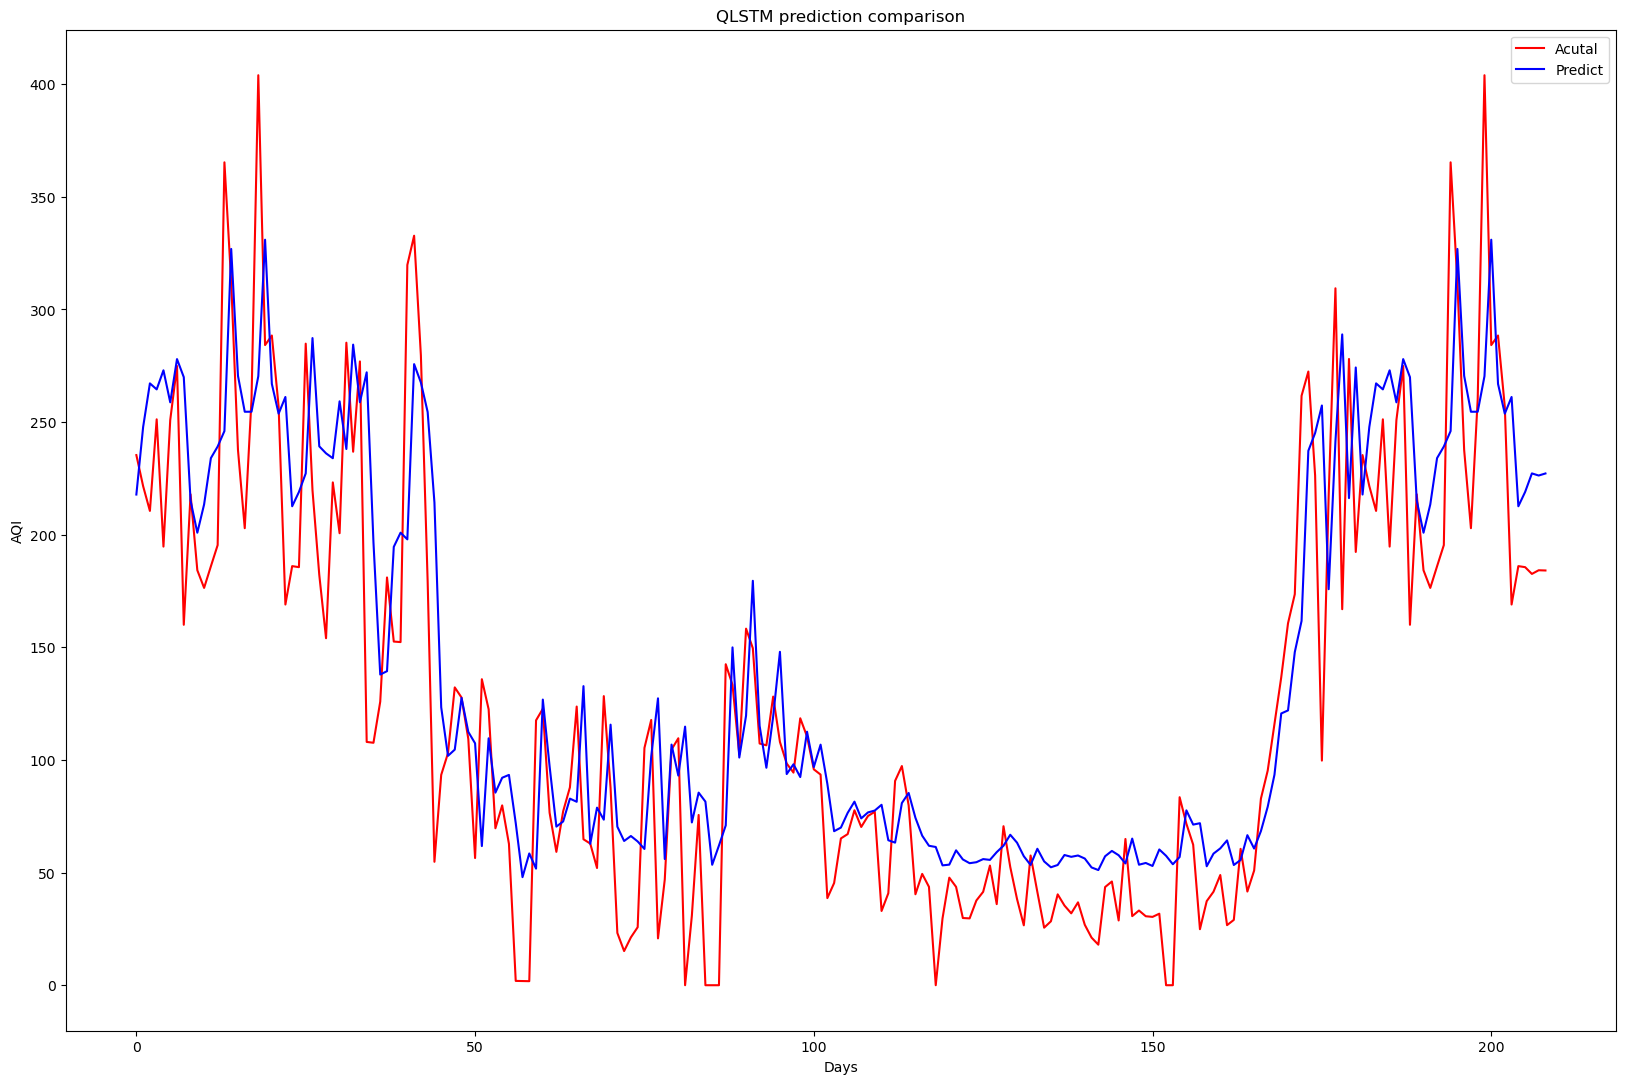

In [88]:
plt.figure(figsize=(20, 13))
plt.plot(y_test_true, color = 'red', label = 'Acutal')
plt.plot(y_test_pred, color = 'blue', label = 'Predict')
plt.title('QLSTM prediction comparison')
plt.ylabel('AQI')
plt.xlabel('Days')
plt.legend(loc = 'upper right')

MSE = mean_squared_error(y_test_true, y_test_pred)
RMSE = math.sqrt(MSE)
print(f'Training dataset RMSE:{RMSE}')